In [1]:
import swirl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools_core as et

In [2]:
model = 'geneva_200m'
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-01T22:00:00.000000000"
t_index = 3

# Open MITgcm results

In [3]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [4]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index=0)

In [5]:
snapshot = data_aligned.isel(time=t_index)

In [6]:
x_plot, y_plot = np.meshgrid(snapshot['lon'], snapshot['lat'])
u_plot = snapshot['UVEL'].values
v_plot = snapshot['VVEL'].values

In [7]:
u_plot = np.where(np.isnan(u_plot), 0, u_plot).T
v_plot = np.where(np.isnan(v_plot), 0, v_plot).T

In [8]:
dx = data_aligned.dxC.values[0][0]
dy = data_aligned.dyC.values[0][0]

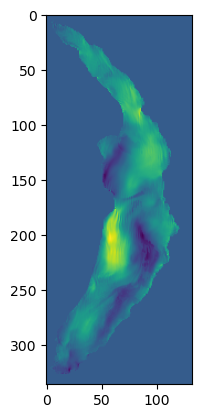

In [9]:
plt.imshow(u_plot)

# Compute SWIRL vortices

In [10]:
vortices = swirl.Identification(v=[u_plot, v_plot],
                                grid_dx=[dx,dy],
                                param_file='../swirl_03.param',
                                verbose=True)

---------------------------------------------------------
---                                                   ---
---    _/_/_/  _/          _/  _/   _/_/_/    _/      ---
---  _/         _/        _/   _/   _/    _/  _/      ---
---    _/_/      _/      _/    _/   _/_/_/    _/      ---
---        _/     _/ _/ _/     _/   _/  _/    _/      ---
---  _/_/_/        _/  _/      _/   _/   _/   _/_/_/  ---
---                                                   ---
---------------------------------------------------------
---------------------------------------------------------
---                                                   ---
---               (c) IRSOL, 11.04.2022               ---
---                                                   ---
--- Author:      José Roberto Canivete Cuissa         ---
--- Email:       jcanivete@ics.uzh.ch                 ---
---------------------------------------------------------
---
--- Parameters:
---------------
---    grid_dx          : 200.0, 200

In [11]:
vortices.run()

---------------------------------------------------------
--- Starting identification 
---------------------------------------------------------
---
--- Computing EVC map
--- Clustering
--- Detecting vortices
---
---------------------------------------------------------
--- Identification completed 
---------------------------------------------------------
---
--- Identified vortices: 10
---
--- Timings
---    Rortex     :    587.136 ms
---    EVC map    :    601.584 ms
---    Clustering :    230.819 ms
---    Detection  :    125.412 ms
---    Total      :    1.545 s  
---------------------------------------------------------


# Various SWIRL output displays

In [14]:
# rortex
plt.figure(figsize=(15,5))
plt.imshow(vortices.rortex[0].T, cmap='PiYG', vmin=-0.01, vmax=0.01)
plt.gca().invert_yaxis()
cbar=plt.colorbar()
cbar.set_label('Rortex R')

# streamlines
nx_grid = vortices.v.x.shape[0]
ny_grid = vortices.v.x.shape[1]
xrange = np.arange(0, nx_grid)
yrange = np.arange(0, ny_grid)
xgrid, ygrid = np.meshgrid(xrange, yrange)
ugrid = snapshot['UVEL'].values
vgrid = snapshot['VVEL'].values
plt.streamplot(xgrid, ygrid, ugrid, vgrid, 
               density=10, color='black', linewidth=0.5, 
               arrowsize=0.7, arrowstyle='->')

# Extent
for vortex in vortices:
    plt.scatter(vortex.vortex_cells[0], vortex.vortex_cells[1], s=0.2, c='blue')
    plt.scatter(vortex.center[0], vortex.center[1],marker='*', s=50, c='red', zorder=10)

<IPython.core.display.Javascript object>

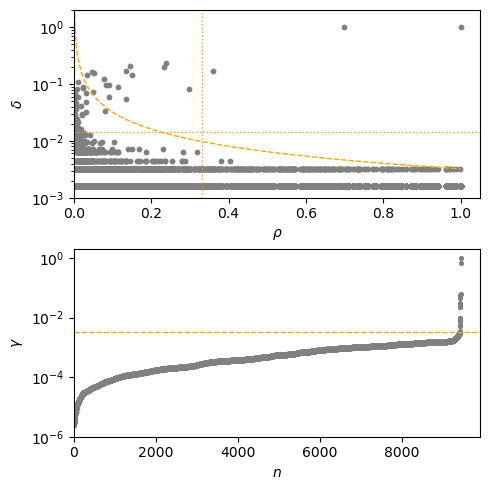

In [13]:
swirl.plot_decision(vortices, save=False)

In [73]:
print(vortices)

---------------------------------------------------------
---                                                   ---
---    _/_/_/  _/          _/  _/   _/_/_/    _/      ---
---  _/         _/        _/   _/   _/    _/  _/      ---
---    _/_/      _/      _/    _/   _/_/_/    _/      ---
---        _/     _/ _/ _/     _/   _/  _/    _/      ---
---  _/_/_/        _/  _/      _/   _/   _/   _/_/_/  ---
---                                                   ---
---------------------------------------------------------
---------------------------------------------------------
---                                                   ---
---               (c) IRSOL, 11.04.2022               ---
---                                                   ---
--- Author:      José Roberto Canivete Cuissa         ---
--- Email:       jcanivete@ics.uzh.ch                 ---
---------------------------------------------------------
---
--- Parameters:
---------------
---    grid_dx          : 200.0, 200

In [14]:
print('Number of identified vortices:', len(vortices))
vortex_0 = vortices[0]
vortex_1 = vortices[1]
print('Vortex N.1:', vortex_0)
print('Vortex N.2:', vortex_1)

Number of identified vortices: 8
Vortex N.1: Clockwise vortex,
---        Center : 192.06, 192.06,
---        Radius : 6.48;
Vortex N.2: Clockwise vortex,
---        Center : 255.44, 255.44,
---        Radius : 5.17;


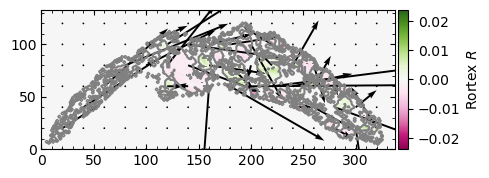

In [15]:
swirl.plot_rortex(vortices, f_quiver=20, save=False)

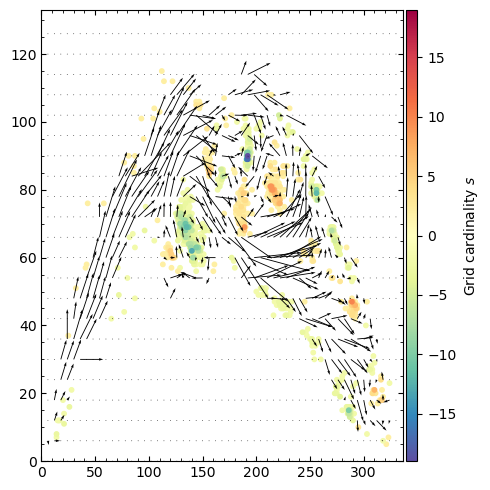

In [16]:
swirl.plot_gevc_map(vortices, f_quiver=6, save=False)

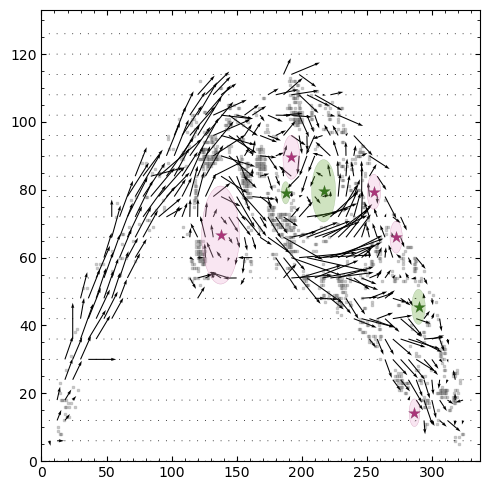

In [18]:
swirl.plot_vortices(vortices, save=False)

# Save results

In [21]:
def interpolate_value_from_index(coord_array_1d, index):
    return np.interp(index, np.arange(len(coord_array_1d)), coord_array_1d)

In [24]:
eddy_list = []
id=0

for eddy in vortices:
    eddy_list.append({
        'eddy_id': id,
        'time': snapshot.time.values,
        'x_center': interpolate_value_from_index(snapshot.lon.values, eddy.center[0]),
        'y_center': interpolate_value_from_index(snapshot.lat.values, eddy.center[1]),
        'radius': eddy.radius,
        'x_extent': [interpolate_value_from_index(snapshot.lon.values, i_eddy) for i_eddy in eddy.vortex_cells[0]],
        'y_extent': [interpolate_value_from_index(snapshot.lat.values, j_eddy) for j_eddy in eddy.vortex_cells[1]],
        'type': -1 * eddy.orientation,
    })
    id +=1

# Build a xarray
max_extent_len = max(len(e['x_extent']) for e in eddy_list)
x_extent_array = np.full((len(eddy_list), max_extent_len), np.nan)
y_extent_array = np.full((len(eddy_list), max_extent_len), np.nan)
for i, e in enumerate(eddy_list):
    x_extent_array[i, :len(e['x_extent'])] = e['x_extent']
    y_extent_array[i, :len(e['y_extent'])] = e['y_extent']

eddy_ds = xr.Dataset(
    data_vars={
        'x_center': ('eddy_id', np.array([e['x_center'] for e in eddy_list])),
        'y_center': ('eddy_id', np.array([e['y_center'] for e in eddy_list])),
        'radius': ('eddy_id', np.array([e['radius'] for e in eddy_list])),
        'x_extent': (('eddy_id', 'extent_index'), x_extent_array),
        'y_extent': (('eddy_id', 'extent_index'), y_extent_array),
        'type': ('eddy_id', np.array([e['type'] for e in eddy_list])),
    },
    coords={
        'eddy_id': np.array([e['eddy_id'] for e in eddy_list]),
        'time': ('eddy_id', np.array([e['time'] for e in eddy_list])),
    }
)

In [26]:
eddy_ds.isel(eddy_id=0)['x_extent'].values

array([36900., 37100., 37100., 37100., 37300., 37300., 37300., 37300.,
       37300., 37300., 37300., 37500., 37500., 37500., 37500., 37500.,
       37500., 37500., 37500., 37500., 37700., 37700., 37700., 37700.,
       37700., 37700., 37700., 37700., 37700., 37900., 37900., 37900.,
       37900., 37900., 37900., 37900., 37900., 37900., 37900., 38100.,
       38100., 38100., 38100., 38100., 38100., 38100., 38100., 38300.,
       38300., 38300., 38300., 38300., 38300., 38300., 38300., 38300.,
       38300., 38300., 38500., 38500., 38500., 38500., 38500., 38500.,
       38500., 38500., 38500., 38500., 38500., 38700., 38700., 38700.,
       38700., 38700., 38700., 38700., 38700., 38700., 38700., 38700.,
       38700., 38700., 38900., 38900., 38900., 38900., 38900., 38900.,
       38900., 38900., 38900., 38900., 38900., 38900., 38900., 38900.,
       39100., 39100., 39100., 39100., 39100., 39100., 39100., 39100.,
       39100., 39100., 39300., 39300., 39300., 39300., 39300., 39300.,
      

In [65]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for id in eddy_ds.eddy_id:
        lon_eddy = snapshot_eddies.sel(eddy_id=id)['x_extent'].values.tolist()
        lat_eddy = snapshot_eddies.sel(eddy_id=id)['y_extent'].values.tolist()

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=1)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='darkgreen')
        # Eddy center
        color = ['gold' if snapshot_eddies.sel(eddy_id=id).type.values == -1 else 'green']
        plt.scatter(snapshot_eddies.sel(eddy_id=id)['x_center'], snapshot_eddies.sel(eddy_id=id)['y_center'], c=color, zorder=10)

    plt.text(0.02, 0.98, f'Z={round(float(snapshot_vel.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

In [66]:
fig=plot_map_eddies(snapshot, eddy_ds, 'test', stream_density = 2)

TypeError: imshow() got multiple values for argument 'cmap'

<Figure size 1200x700 with 0 Axes>